# Overview

This notebook covers exploratory analysis and data visualisation of customer service chat data (**ops_data.csv**) between the period 2021-07-01 to 2022-06-29, as well as a forecast for chat data until the end of 2022. This is the first time this dataset has been analysed.

**Key recommendation:** Increase the agent headcount growth rate to keep up with the growth in chat demand. Increase the number of temporary agents through the peak months of December and January.

### Python libraries needed to follow this notebook
- matplotlib
- pandas
- numpy
- seaborn
- sklearn

## Steps:
* [Import libraries and read in the data](#import)
* [Check the validity of the data](#validity)
* [Modify datatypes and compute new columns](#modify)
* [Exploratory analysis](#explore)
    * [Rating vs. wait time](#ratingvswait)
        * [How does wait time vary through the year?](#waitvariation)
            * [Has supply of agents increased to meet the increase in demand (waiting time)?](#supplydemand)
        * [How does demand (waiting time) vary through the week?](#variationweek)
            * [Does supply of agents vary throughout the week to meet changing demand (waiting time)?](#supplydemandweek)
        * [How does demand (waiting time) vary throughout the day?](#variationday)
    * [Chat duration over time](#duration)
    * [Proportion of customers that leave a rating over time](#proportion)
* [Forecast for the number of chats until the end of 2022](#forecast)
* [Further work](#furtherwork)

# Import libraries and read in the data <a id='import'></a>

In [833]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
from sklearn.linear_model import LinearRegression

df = pd.read_csv("ops_data.csv")

Check that the data has been imported correctly:

In [834]:
df

,Chat Start Date,Chat Start Time,Chat End Time,Customer Wait Time,Chat Duration,Chat Closed By,Chat ID,Customer Rating
0,2021-07-01,06:00:36,06:12:02,00:21:25,00:11:26,agent,54873,NaN
1,2021-07-01,06:00:40,06:14:12,00:21:45,00:13:32,agent,54874,NaN
2,2021-07-01,06:01:57,06:11:04,00:21:49,00:09:07,agent,54875,NaN
3,2021-07-01,06:02:15,06:12:32,00:23:20,00:10:17,agent,54876,NaN
4,2021-07-01,06:03:02,06:13:54,00:23:38,00:10:52,customer,54877,NaN
...,...,...,...,...,...,...,...,...
393230,2022-06-29,19:55:09,20:02:13,00:35:32,00:07:04,agent,448107,3.0
393231,2022-06-29,19:57:51,20:04:29,00:32:20,00:06:38,agent,448108,3.0
393232,2022-06-29,19:58:09,20:05:43,00:34:40,00:07:34,agent,448109,2.0
393233,2022-06-29,19:58:23,20:06:26,00:33:50,00:08:03,customer,448110,3.0


In [835]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393235 entries, 0 to 393234
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Chat Start Date     393235 non-null  object 
 1   Chat Start Time     393235 non-null  object 
 2   Chat End Time       393235 non-null  object 
 3   Customer Wait Time  393235 non-null  object 
 4   Chat Duration       393235 non-null  object 
 5   Chat Closed By      393235 non-null  object 
 6   Chat ID             393235 non-null  int64  
 7   Customer Rating     268447 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 24.0+ MB


Rename columns to make these snakecase and shorter, to be easier to work with:

In [836]:
df.rename(columns={'Chat Start Date': 'date', 'Chat Start Time': 'start', 'Chat End Time': 'end', 'Customer Wait Time': 'wait',
                   'Chat Duration': 'duration', 'Chat Closed By': 'closed_by', 'Chat ID': 'id', 'Customer Rating': 'rating'}, inplace=True)

Check that columns have been renamed correctly:

In [837]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393235 entries, 0 to 393234
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       393235 non-null  object 
 1   start      393235 non-null  object 
 2   end        393235 non-null  object 
 3   wait       393235 non-null  object 
 4   duration   393235 non-null  object 
 5   closed_by  393235 non-null  object 
 6   id         393235 non-null  int64  
 7   rating     268447 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 24.0+ MB


# Check the validity of the data <a id='validity'></a>

Check range and value counts of the 'Chat Start Date' values:

In [838]:
df["date"].value_counts().sort_index()

2021-07-01    1004
2021-07-02    1013
2021-07-03     963
2021-07-04    1007
2021-07-05    1002
              ... 
2022-06-25    1165
2022-06-26    1127
2022-06-27    1169
2022-06-28    1133
2022-06-29    1167
Name: date, Length: 364, dtype: int64

Range of dates is as expected, and number of calls per day is ~1000, which seems sensible.

Check range and value counts of the 'Chat Start Date' values:

In [839]:
df["start"].value_counts().sort_index()

06:00:00    11
06:00:01     3
06:00:02     9
06:00:03     8
06:00:04     9
            ..
19:59:55     8
19:59:56    12
19:59:57     7
19:59:58     8
19:59:59    11
Name: start, Length: 50389, dtype: int64

Range of times seems sensible.

Check range and value counts of the 'Chat End Date' values:

In [840]:
df["end"].value_counts().sort_index()

06:04:02    1
06:04:08    1
06:04:35    1
06:04:56    1
06:05:02    1
           ..
20:12:11    1
20:12:14    1
20:12:19    1
20:12:29    2
20:13:19    1
Name: end, Length: 50664, dtype: int64

Range of times seems sensible.

Check range and value counts of the 'Customer Wait Time' values: 

In [841]:
df["wait"].value_counts().sort_index()

-1 day,     16643
00:00:00       35
00:00:01       37
00:00:02       32
00:00:03       28
            ...  
01:48:56        1
01:49:01        1
01:49:05        1
01:49:15        1
01:49:18        1
Name: wait, Length: 6477, dtype: int64

~16,000 rows contain the value "-1 day," - it is unclear what this means.
Question: is there a bug that is causing this?

Investigate the rows that contain "-1 day,":

In [842]:
df[df["wait"] == "-1 day,"]

,date,start,end,wait,duration,closed_by,id,rating
2017,2021-07-03,06:00:19,06:10:31,"-1 day,",00:10:12,agent,56890,NaN
2018,2021-07-03,06:00:22,06:09:10,"-1 day,",00:08:48,agent,56891,NaN
2019,2021-07-03,06:01:25,06:10:43,"-1 day,",00:09:18,agent,56892,NaN
2020,2021-07-03,06:02:07,06:11:19,"-1 day,",00:09:12,customer,56893,NaN
2021,2021-07-03,06:02:13,06:12:21,"-1 day,",00:10:08,agent,56894,NaN
...,...,...,...,...,...,...,...,...
294894,2022-04-04,19:22:16,19:27:41,"-1 day,",00:05:25,customer,349770,5.0
294914,2022-04-04,19:40:03,19:44:01,"-1 day,",00:03:58,customer,349790,5.0
294923,2022-04-04,19:49:38,19:55:19,"-1 day,",00:05:41,agent,349799,5.0
294927,2022-04-04,19:51:06,19:57:20,"-1 day,",00:06:14,customer,349803,5.0


All other values in these rows seem sensible.

Investigate the numbers of dates that are affected by the "-1 day," values:

In [843]:
df["date"][df["wait"] == "-1 day,"].value_counts().sort_index()

2021-07-03     963
2021-07-13     976
2021-07-14     979
2021-07-19     970
2021-07-23     982
2021-07-26     923
2021-07-28     976
2021-07-29     985
2021-08-12     967
2021-08-19     145
2021-08-26     985
2021-08-30       1
2021-09-04     996
2021-09-13     910
2021-09-19     143
2021-09-28      17
2021-10-21     908
2021-10-29     594
2021-11-06      33
2021-11-13    1007
2021-11-15    1006
2022-04-01    1067
2022-04-03      29
2022-04-04      81
Name: date, dtype: int64

Only a few dates are affected and the number of times this occurs seems fairly random. It is unclear why this is. For now these "-1 day," values will be set to null values:

In [844]:
df["wait"] = df["wait"].replace({"-1 day,": pd.NA})
df["wait"].value_counts().sort_index()

00:00:00    35
00:00:01    37
00:00:02    32
00:00:03    28
00:00:04    26
            ..
01:48:56     1
01:49:01     1
01:49:05     1
01:49:15     1
01:49:18     1
Name: wait, Length: 6476, dtype: int64

The remaining wait times seem sensible.

Check that the "Chat Closed By" values are only "agent" or "customer":

In [845]:
df["closed_by"].unique()

array(['agent', 'customer'], dtype=object)

Check that the "Chat ID" values are all unique:

In [846]:
len(df["id"].unique())

393235

There are 393235 unique ID's, which matches the number of rows in the dataset.

Check the range of "Chat ID" values:

In [847]:
max(df["id"]) - min(df["id"])

393238

It appears that 4 chats are missing. Question: what has happened to these? If needed, the dates and times of these could be estimated by looking at the chat ids either side of the missing values.

Check that the "Customer Rating" values are only 1-5 stars or null vaulues:

In [848]:
df["rating"].unique()

array([nan,  2.,  4.,  3.,  5.,  1.])

# Modify datatypes and compute new columns <a id='modify'></a>

Modify date/ time values to datetime format, to make these easier to work with: 

In [849]:
df["date"] = pd.to_datetime(df["date"])
df["start"] = pd.to_datetime(df["start"])
df["end"] = pd.to_datetime(df["end"])
df["wait"] = pd.to_datetime(df["wait"])
df["duration"] = pd.to_datetime(df["duration"])

Add new columns to convert wait times and chat durations from hours/minutes/seconds to minutes:

In [850]:
df["wait_minutes"] = df['wait'].dt.hour*60 + df['wait'].dt.minute + df['wait'].dt.second/60
df["duration_minutes"] = df['duration'].dt.hour*60 + df['duration'].dt.minute + df['duration'].dt.second/60

Add new column for weekday codes and hour of the chat start time:

In [851]:
df["day_code"] = df["date"].dt.weekday # asssign each day of the week a number where 0 is Monday and 6 is Sunday
df['start_hour'] = df['start'].dt.hour

Add new binary columns for who the chats were closed by, and whether the chats have a rating:

In [852]:
df["closed_by_code"] = df["closed_by"].replace({"agent": 1}) # overwrite "agent" with the value 1
df["closed_by_code"] = df["closed_by"].replace({"customer": 0}) # overwrite "customer" with the value 0
df['has_rating'] = (df['rating'].notnull()).astype("int") # assign 1 to chats that have a rating and 0 to chats that do not

Check all datatypes are as expected:

In [853]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393235 entries, 0 to 393234
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              393235 non-null  datetime64[ns]
 1   start             393235 non-null  datetime64[ns]
 2   end               393235 non-null  datetime64[ns]
 3   wait              376592 non-null  datetime64[ns]
 4   duration          393235 non-null  datetime64[ns]
 5   closed_by         393235 non-null  object        
 6   id                393235 non-null  int64         
 7   rating            268447 non-null  float64       
 8   wait_minutes      376592 non-null  float64       
 9   duration_minutes  393235 non-null  float64       
 10  day_code          393235 non-null  int64         
 11  start_hour        393235 non-null  int64         
 12  closed_by_code    393235 non-null  object        
 13  has_rating        393235 non-null  int32         
dtypes: d

# Exploratory analysis <a id='explore'></a>

Plot the correlation matrix of the data including the new columns:

<AxesSubplot:>

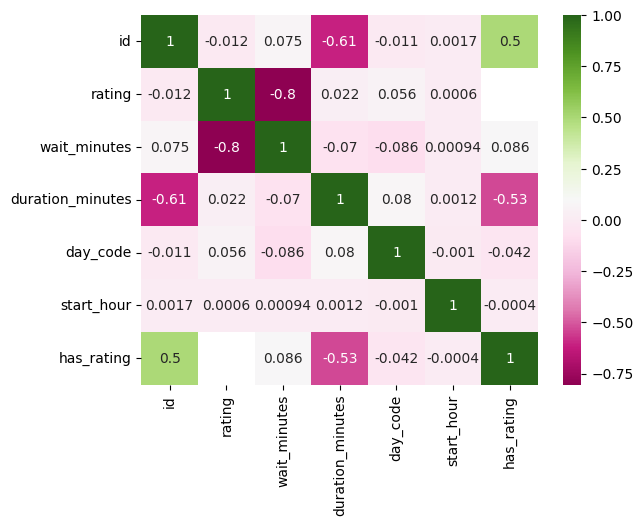

In [854]:
corr = df.corr()
sb.heatmap(corr, cmap="PiYG", annot=True)

The strong correlations in this matrix are:

1. rating vs. wait time - strong negative correlation - this makes sense - the longer you keep a customer waiting, the more unhappy they are likely to be.

2. id vs. duration - negative correlation - this makes sense - agents are learning/ able to solve customer queries quicker over time.

3. id vs. has_rating - positive correlation - this implies that more customers are leaving the optional ratings over time, which is good.

4. duration vs. has_rating - negative correlation - this implies that the longer a chat takes, the less likely a customer is to leave a rating. This makes sense, however, it is more likley to be a combination of correlations 2 and 3, which seem stronger individually.

Each of these will be looked at in more detail below:

## Rating vs. wait time <a id='ratingvswait'></a>

<AxesSubplot:title={'center':'wait_minutes'}, xlabel='rating'>

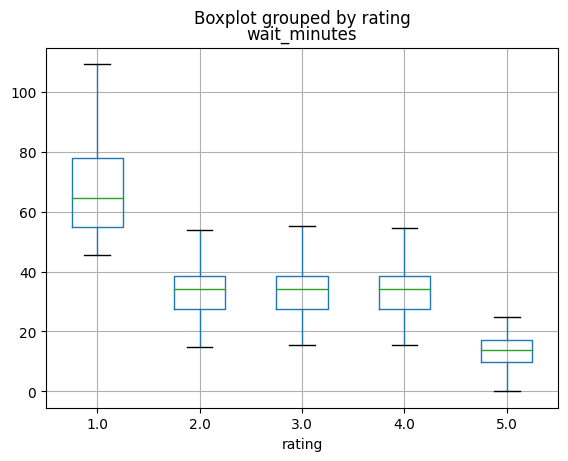

In [855]:
df.boxplot(column='wait_minutes', by='rating')

5 star waitings are only recieved when the customer has waited for less than ~25 minutes, and likewise keeping a customer waiting for more than ~55 minutes will only achieve a 1 star rating. 2-4 star ratings have very similar distributions, implying that customers in this region are relatively indifferent to wait time.

### How does wait time vary through the year? <a id='waitvariation'></a>

Plotting the average wait time per day:

<AxesSubplot:xlabel='date'>

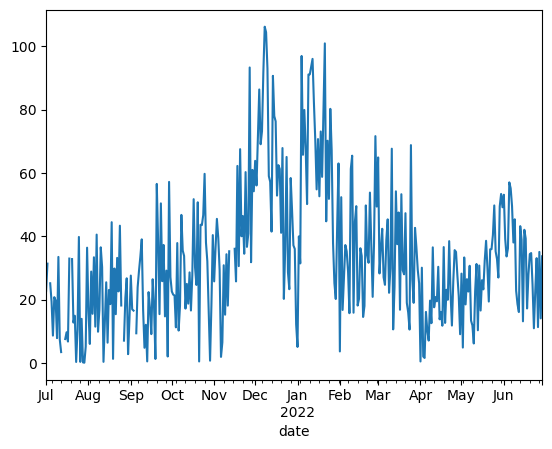

In [856]:
df.groupby('date')['wait_minutes'].mean().plot(kind='line')

This plot is fairly noisy, but two separate surges in wait time can be seen in both December and January. Reasons for this could be e.g. surges in spending in December for Christmas, and new phones bought for Christmas being set up in January.

Easier to read this data if grouped by month:

<AxesSubplot:xlabel='month'>

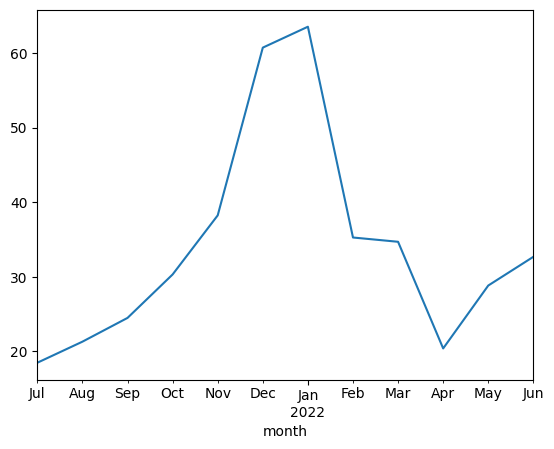

In [857]:
df["month"] = df["date"].dt.to_period('M')
df.groupby('month')['wait_minutes'].mean().plot(kind='line')

December and January see over a 200% increase in wait time compared to July, and obviously (given the correlation) the average monthly customer ratings consequently plummet to less than 2 stars for these months:

<AxesSubplot:xlabel='month'>

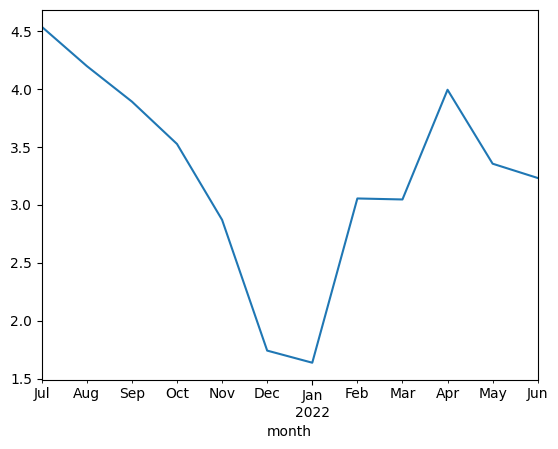

In [858]:
df.groupby('month')['rating'].mean().plot(kind='line')

There is also a trend of increased wait time/ reduced customer rating over the full period.

### Has supply of agents increased to meet the increase in demand (waiting time)? <a id='supplydemand'></a>

Plotting the average number of chats per day:

<AxesSubplot:>

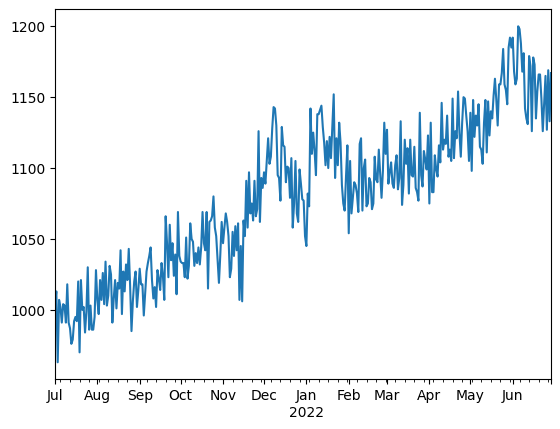

In [859]:
df["date"].value_counts().sort_index().plot(kind='line')

Number of chats has linearly increased by around 15% through the full period. This could be due growth in the headcount of agents, or shortening durations of chats allowing more calls to be answered over time.

However, the increase in the number of chats does not keep up with the increase in wait times through the period.
Also, although there are small increases in the number of chats through December and January, this nowhere near meets the increase in surge demand.

Recommendation: Increase the agent headcount growth rate to keep up with the growth in demand. Increase the number of temporary agents through the peak months of December and January.

### How does demand (waiting time) vary through the week? <a id='variationweek'></a>

Plotting the average wait time per day of the week:

[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

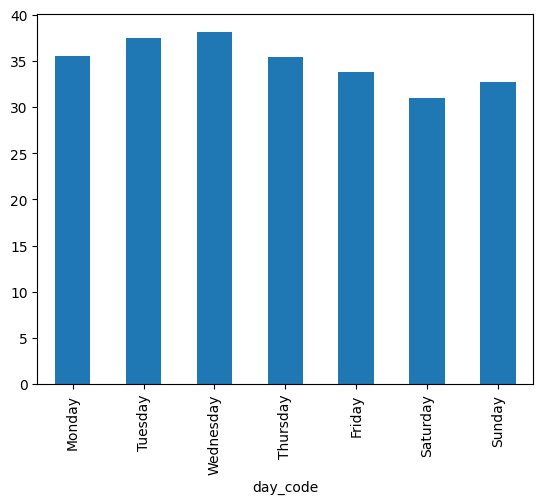

In [860]:
daysofweek = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df.groupby('day_code')['wait_minutes'].mean().plot(kind='bar').set_xticklabels(daysofweek)

Wednesday sees the longest average wait time, whilst Saturday sees the shortest.

### Does supply of agents vary throughout the week to meet changing demand (waiting time)? <a id='supplydemandweek'></a>

Plotting the average number of chats per day of the week:

[Text(0, 0, 'Monday'),
 Text(1, 0, 'Tuesday'),
 Text(2, 0, 'Wednesday'),
 Text(3, 0, 'Thursday'),
 Text(4, 0, 'Friday'),
 Text(5, 0, 'Saturday'),
 Text(6, 0, 'Sunday')]

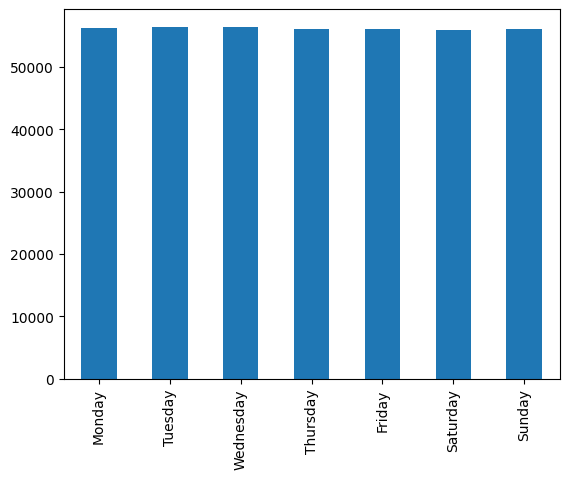

In [861]:
df["day_code"].value_counts().sort_index().plot(kind='bar').set_xticklabels(daysofweek)

Supply of agents does not vary throughout the week to meet changing demand. Question: Would changing this lead to an increase in ratings? 

### How does demand (waiting time) vary throughout the day? <a id='variationday'></a>

Plotting the average waiting time per hour through the day:

<AxesSubplot:xlabel='start_hour'>

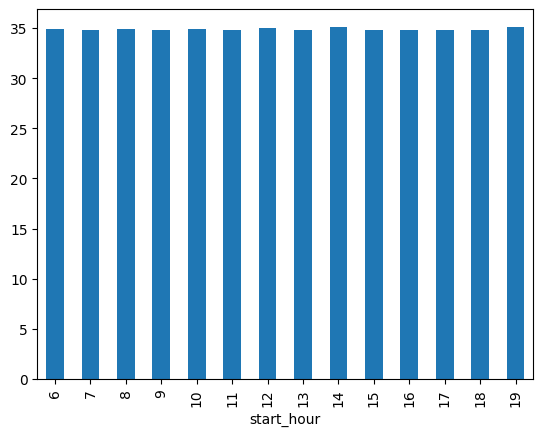

In [862]:
df.groupby('start_hour')['wait_minutes'].mean().plot(kind='bar')

Demand does not seem to vary throughout the day, which is unexpected.

## Chat duration over time <a id='duration'></a>

Plotting the average duration per month:

<AxesSubplot:xlabel='month'>

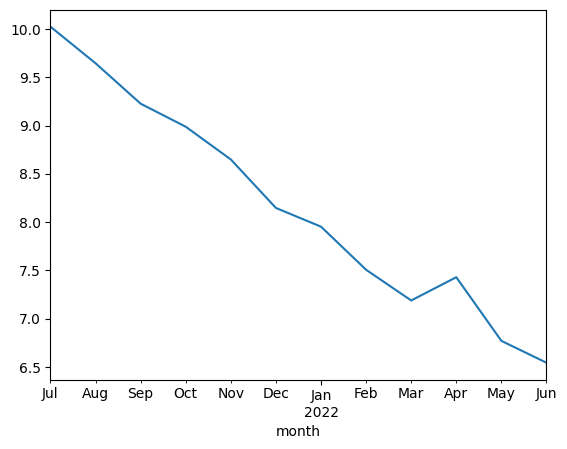

In [863]:
df.groupby('month')['duration_minutes'].mean().plot(kind='line')

This is a very positive trend, as decreasing the duration of chats will decrease wait times, and therefore increase customer ratings. It is expected that this trend will continue at a decreasing rate, as the average duration approaces zero.

## Proportion of customers that leave a rating over time <a id='proportion'></a>

Plotting the proportion of customers that left a rating each month:

<AxesSubplot:xlabel='month'>

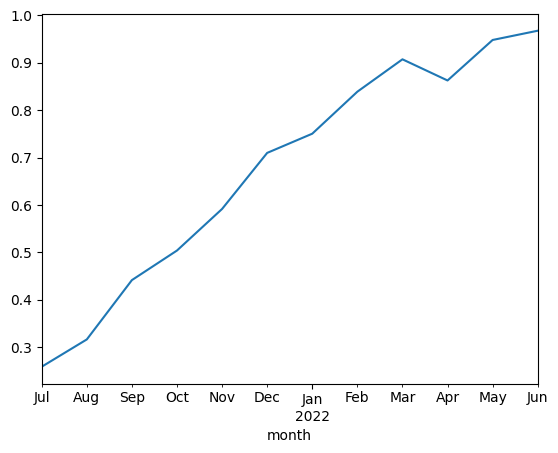

In [864]:
df.groupby('month')['has_rating'].mean().plot(kind='line')

Again, this is a very positive trend, and almost all customers are now leaving ratings. This may be due to the process of leaving a rating being made easier for the customer.

# Forecast for the number of chats until the end of 2022 <a id='forecast'></a>

As the number of chats increased linearly through the period, it has been chosen to use linear regression to forecast the number of chats until the end of 2022.

In [865]:
chats_per_day = df["date"].value_counts().sort_index()
days_past = df["date"].unique()

x = pd.DataFrame(np.array([list(range(1, 365))]).T) # number the days through the period
y = pd.DataFrame(np.array([chats_per_day]).T)  

model = LinearRegression().fit(x, y) # fit the model
r_sq = model.score(x, y) # check fit of the model
print(f"coefficient of determination: {r_sq}")

y_past = model.predict(x) # predict points to make trendline for existing data

days_future = pd.date_range(start = "2022-07-01", end = "2022-12-31")

x_future = pd.DataFrame(np.array([list(range(365, 365+len(days_future)))]).T)  # continue numbering of days in the forecast period
y_future = model.predict(x_future) # predict points to make trendline for forecasted data


coefficient of determination: 0.8143388324848612


The R squared value shows a fairly good fit for the model.

## Visualise the forecast <a id='import'></a>

Red is the trendline for the existing data, and green is an extension of this trendline into the forecasted region.

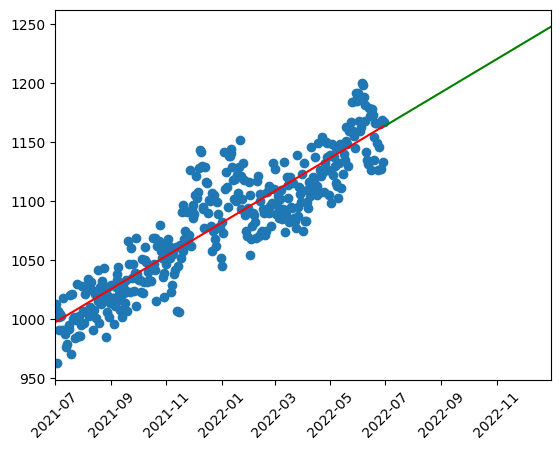

In [866]:
plt.scatter(days_past, chats_per_day)
plt.plot(days_past, y_past, color='red')
plt.plot(days_future, y_future, color='green')
plt.xlim(xmin = min(days_past), xmax = max(days_future))
plt.xticks(rotation = 45)
plt.show()

Total number of chats in the forecasted region:

In [867]:
sum(y_future).round().astype(int)[0] # total number of chats in the forecasted region

221870

Question: in what format is the forecasted data needed? E.g. monthly, weekly, daily?

# Further work <a id='further work'></a>

- Collate the key plots from this notebook, improve the readability of them in a visualisation tool (e.g. Looker) and circulate them to a wider audience. 
- More accurately forecast the expected surge in demand in December 2022.
- What happens to customers that give up waiting for a chat to be started? Can this data be tracked?
    - Are these the customers that are most likely to be lost?
- Investigate variation in weekday demand through the period.
    - e.g. are Fridays seeing higher demand in 2022?
- Why are the ~5% of remaining customers not leaving ratings?
- Would varying agent shifts throughout the week to equalise wait time increase average ratings? Is this even plausible?
- Are customers less tolerant of longer waiting times on different days of the week?
    - e.g. would customers waiting for 20 minutes on a Monday leave a lower ratings than those waiting 20 minutes on Sunday? 
    